In [1]:
import os
import json
import time
import copy
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import lovely_tensors as lt # can be removed
import numpy as np
import dill
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from fl2o.optimizee import MLPOptee, CustomParams
from fl2o.optimizee_modules import MetaParameter
from fl2o.optimizer import GD, Adam, FGD, AFOGD, CFGD, CFGD_ClosedForm, L2O_Update
from fl2o.l2o import L2O
from fl2o.data import MNIST, CustomTask, generate_least_squares_task, H1, H2, H3
from fl2o.training import do_fit, find_best_lr, meta_train, get_optimal_lr, n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee, parallel_n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee
from fl2o.utils import dict_to_str, plot_log, plotter, plot_metrics, apply_publication_plt_settings, plot_strategy

lt.monkey_patch() # can be removed

DATA_PATH = os.getenv("DATA_PATH")
CKPT_PATH = os.getenv("CKPT_PATH")
DEVICE = os.getenv("DEVICE", "cpu")

print(f"{DATA_PATH=}\n{CKPT_PATH=}\n{DEVICE=}")

DATA_PATH='/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/data'
CKPT_PATH='/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/ckpt'
DEVICE='cuda:3'


In [2]:
### load previous checkpoint (and skip meta-training of a new l2O optimizer)
ckpt = torch.load(
    os.path.join(
        CKPT_PATH,
        "l2o",
        "13-06_13-12__L2O__CFGD",
        "ckpt.pt"
        # "meta_training",
        # "20.pt",
    ),
    map_location=torch.device(DEVICE),
    pickle_module=dill,
)
config = ckpt["config"]
config["device"] = DEVICE
print(json.dumps(config, indent=4, default=str))

l2o_dict = ckpt["l2o_dict"]
l2o_dict_best = ckpt["l2o_dict_best"]
if "opter" not in l2o_dict_best:
    l2o_dict_best["best_l2o_dict"]["opter"] = config["opter"]["opter_cls"](**config["opter"]["opter_config"])
    l2o_dict_best["best_l2o_dict"]["opter"].load_state_dict(l2o_dict_best["best_l2o_dict"]["opter_state_dict"])
    l2o_dict_best["best_l2o_dict"]["meta_opter"] = config["meta_training_config"]["meta_opter_cls"](
        params=l2o_dict_best["best_l2o_dict"]["opter"].parameters(),
        **config["meta_training_config"]["meta_opter_config"],
    )
    l2o_dict_best["best_l2o_dict"]["meta_opter"].load_state_dict(l2o_dict_best["best_l2o_dict"]["meta_opter_state_dict"])
l2o_dict_best["best_l2o_dict"]["opter"].device = DEVICE
l2o_dict_best["best_l2o_dict"]["opter"].to(DEVICE)
l2o_dict["opter"].device = DEVICE
l2o_dict["opter"].to(DEVICE)
log = ckpt["log"]

### l2o
# ckpt_2 = torch.load(
#     os.path.join(
#         CKPT_PATH,
#         "l2o",
#         "06-06_10-24__L2O__L2O_Update",
#         "ckpt.pt"
#         # "meta_training",
#         # "20.pt",
#     ),
#     map_location=torch.device(DEVICE),
#     pickle_module=dill,
# )
# l2o_dict_2 = ckpt_2["l2o_dict"]
# l2o_dict_best_2 = ckpt_2["l2o_dict_best"]
# l2o_dict_best_2["best_l2o_dict"]["opter"].device = DEVICE
# l2o_dict_2["opter"].device = DEVICE
# log_2 = ckpt_2["log"]
# config_2 = ckpt_2["config"]
# print(json.dumps(config_2, indent=4, default=str))

{
    "time": "13-06_13-12",
    "data": {
        "data_cls": "<class 'fl2o.data.H3'>",
        "data_config": {
            "preload_n_samples": 100,
            "device": "cuda:2"
        }
    },
    "optee": {
        "optee_cls": "<class 'fl2o.optimizee.MLPOptee'>",
        "optee_config": {
            "layer_sizes": [
                50
            ],
            "inp_size": 1,
            "out_size": 1,
            "act_fn": "Tanh()",
            "output_bias": false,
            "device": "cuda:2"
        }
    },
    "opter": {
        "opter_cls": "<class 'fl2o.l2o.L2O'>",
        "opter_config": {
            "in_dim": 3,
            "out_dim": 3,
            "hidden_sz": 40,
            "in_features": [
                "grad",
                "iter_num_enc"
            ],
            "device": "cuda:2",
            "base_opter_cls": "<class 'fl2o.optimizer.CFGD'>",
            "base_opter_config": {
                "lr": "<function per_param_n_step_lookahead_lr_search_hfu

## Univariate hyperbolic tangent two-layer neural network
Section 4.3 in "Accelerating gradient descent and Adam via fractional gradients" by Y. Shin et al. 2023

### Meta-training

In [ ]:
config = {
    "time": datetime.now().strftime("%d-%m_%H-%M"),
}

### data (task)
config["data"] = {
    "data_cls": H2,
}
config["data"]["data_config"] = {
    "preload_n_samples": 100,
    "device": DEVICE,
}

### optimizee
config["optee"] = {
    "optee_cls": MLPOptee,
    "optee_config": {
        "layer_sizes": [50],
        "inp_size": 1,
        "out_size": 1,
        "act_fn": nn.Tanh(),
        "output_bias": False,
        "device": DEVICE,
    },
}

### optimizer L2O-CFGD
config["opter"] = {
    "opter_cls": L2O,
    "opter_config": {
        "in_dim": 3, # len(in_features) + 1
        "out_dim": 3,
        "hidden_sz": 40,
        "in_features": ("grad", "iter_num_enc"),
        "device": DEVICE,
        "base_opter_cls": CFGD,
        "base_opter_config": {
            "lr": 0.005,
            "alpha": None,
            "beta": None,
            "c": None,
            "s": 1,
            "version": "NA",
            "init_points": None,
            "detach_gauss_jacobi": True,
            "device": DEVICE,
        },
        "params_to_optimize": {
            "alpha": {
                "idx": 0,
                "act_fns": ("sigmoid",),
            },
            "beta": {
                "idx": 1,
                "act_fns": ("identity",),
            },
            "c": {
                "idx": 2,
                "act_fns": ("identity",),
            },
        },
    },
}

### optimizer L2O
# config["opter"] = {
#     "opter_cls": L2O,
#     "opter_config": {
#         "in_dim": 3, # len(in_features) + 1
#         "out_dim": 1,
#         "hidden_sz": 40,
#         "in_features": ("grad", "iter_num_enc"),
#         "device": DEVICE,
#         "base_opter_cls": L2O_Update,
#         "base_opter_config": {
#             "lr": 0.01,
#             "device": DEVICE,
#         },
#         "params_to_optimize": {
#             "update": {
#                 "idx": 0,
#                 "act_fns": ("identity",),
#             },
#         },
#     },
# }

### meta-training config
config["meta_training_config"] = {
    "meta_opter_cls": optim.Adam,
    "meta_opter_config": {
        "lr": 3e-4,
    },
    "n_runs": 600,
    "unroll": 30,
    "loggers": [
        # {
        #     "every_nth_run": 20,
        #     "logger_fn": partial(plotter, to_plot="c"),
        # }
    ],
}

### other
config.update({
    "n_iters": 1000,
    "l2o_dict": None,
    "additional_metrics": {
        # "gamma": lambda opter, **kwargs: \
        #     # opter.base_opter.param_groups[0]["gamma"].item() \
        #     opter.base_opter.param_groups[0]["gamma"].mean().item() \
        #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("gamma", None),
        # "c": lambda opter, **kwargs: \
        #     # opter.base_opter.param_groups[0]["c"].item() \
        #     opter.base_opter.param_groups[0]["c"].mean().item() \
        #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
        # "l2_dist(x_tik*, x)": lambda task, optee, **kwargs: \
        #     torch.norm(task["x_tik_solution"](gamma=1., c=1) - optee.params.detach(), p=2).item(),
        # "l2_dist(x*, x)": lambda task, optee, **kwargs: \
        #     torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
    },
    "ckpt_config": {
        "ckpt_every_nth_run": 20,
        "ckpt_dir": os.path.join(
            CKPT_PATH,
            "l2o",
            config["time"] + "__"\
                + config["opter"]["opter_cls"].__name__ + "__"\
                + config["opter"]["opter_config"]["base_opter_cls"].__name__,
        ),
    },
    "device": DEVICE,
    "seed": 0,
})
config["ckpt_config"]["ckpt_dir_meta_training"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_training",
)
config["ckpt_config"]["ckpt_dir_meta_testing"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_testing",
)

### make dirs
os.makedirs(config["ckpt_config"]["ckpt_dir"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_training"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_testing"], exist_ok=True)

### save config
with open(os.path.join(config["ckpt_config"]["ckpt_dir"], "config.json"), "w") as f:
    json.dump(config, f, indent=4, default=str)

print(f"Path to checkpoints: {config['ckpt_config']['ckpt_dir']}")
print(os.path.basename(config["ckpt_config"]["ckpt_dir"]))

In [ ]:
optee = config["optee"]["optee_cls"](**config["optee"]["optee_config"])
data = config["data"]["data_cls"](**config["data"]["data_config"])

samples = []
for i in range(200):
    sample = data.sample()
    samples.append([sample["x"].item(), sample["y"].item()])
samples = np.array(sorted(samples, key=lambda s: s[0]))
plt.plot(samples[:, 0], samples[:, 1])

In [ ]:
config["data"]["data_config"]["device"] = DEVICE
config["opter"]["opter_config"]["device"] = DEVICE
config["opter"]["opter_config"]["base_opter_config"]["device"] = DEVICE
config["device"] = DEVICE

In [ ]:
### meta train
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
l2o_dict, l2o_dict_best, log = meta_train(
    config=config,
    device=config["device"],
    ### keep meta-training
    # l2o_dict=l2o_dict,
    # l2o_dict_best=l2o_dict_best,
    # log=log,
)

### save checkpoint
torch.save({
    "l2o_dict": l2o_dict,
    "l2o_dict_best": l2o_dict_best,
    "log": log,
    "config": config,
}, os.path.join(config["ckpt_config"]["ckpt_dir"], "ckpt.pt"), pickle_module=dill)

plt.plot(log["loss_sum"])

### Meta-testing

In [22]:
n_test_runs = 1
test_run_iters = 15000
test_runs_seed = 1

update_config_base = dict()
update_config_base["n_iters"] = test_run_iters
update_config_base["optee"] = {
    "optee_cls": MLPOptee,
    "optee_config": {
        "layer_sizes": [50],
        "inp_size": 1,
        "out_size": 1,
        "act_fn": nn.Tanh(),
        "output_bias": False,
        "device": DEVICE,
    },
}
# update_config_base["data"] = copy.deepcopy(config["data"])
# update_config_base["data"]["data_cls"] = H1


eval_data = config["data"]["data_cls"](
    preload_n_samples=100_000,
    batch_size=100_000,
    device=DEVICE,
)
def eval_optee(optee):
    optee.eval()

    ### get data
    task_sample = eval_data.sample()

    ### get loss
    y_hat = optee(task=task_sample)
    loss = F.mse_loss(y_hat, task_sample["y"])
    optee.train()

    return loss.item()

update_config_base["additional_metrics"] = {
    # "last_lr": lambda opter, **kwargs: \
    #     copy.deepcopy(opter.state[0]["last_lr"]) if "last_lr" in opter.state[0] \
    #     else copy.deepcopy(opter.param_groups[0]["last_lr"]),
    "last_lr": lambda opter, **kwargs: \
        tuple(copy.deepcopy(s["last_lr"]) for s in opter.state) if "last_lr" in opter.state[0] \
        else tuple(copy.deepcopy(s["last_lr"]) for s in opter.param_groups),
    "test_error": lambda optee, **kwargs: \
        eval_optee(optee=optee)
}


runs = dict()

In [23]:
### GD
runs["GD"] = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": GD,
            "opter_config": {
                "lr": n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee,
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "color": "black",
        "linestyle": "dashed",
    },
    "load_saved": False,
}

In [ ]:
### NA-CFGD
for alpha in [0.95]:
    for beta in [0.]:
        for c in [-0.5]:
            runs[r"NA-CFGD, $\alpha$=" + str(alpha)
                + r" $\beta$=" + str(beta)
                + r" $c$=" + str(c)] = {
                "update_config": {
                    **update_config_base,
                    "opter": {
                        "opter_cls": CFGD,
                        "opter_config": {
                            "lr": n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee,
                            "alpha": alpha,
                            "beta": beta,
                            "c": c,
                            "s": 1,
                            "version": "NA",
                            "init_points": None,
                            "device": DEVICE,
                        },
                    },
                },
                "plot_config": {
                    "linestyle": "dashed",
                },
                "load_saved": False,
            }

In [24]:
### AT-CFGD
_tmp_optee = update_config_base["optee"]["optee_cls"](**update_config_base["optee"]["optee_config"])
for alpha in [0.9]:
    for beta in [-100, -3, -2]:
        runs[r"AT-CFGD, $\alpha$=" + str(alpha)
            + r" $\beta$=" + str(beta)] = {
            "update_config": {
                **update_config_base,
                "opter": {
                    "opter_cls": CFGD,
                    "opter_config": {
                        "lr": parallel_n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee,
                        "alpha": alpha,
                        "beta": beta,
                        "c": None,
                        "s": 1,
                        "n_hutchinson_steps": 5,
                        "version": "AT",
                        "init_points": [
                            [torch.randn_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                        ],
                        "device": DEVICE,
                    },
                },
            },
            "plot_config": {
                "linestyle": "dashed",
            },
            "load_saved": False,
        }

In [ ]:
### L2O
runs["L2O"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "optee": update_config_base["optee"],
        "opter": copy.deepcopy(config["opter"]),
        "additional_metrics": {
            "last_lr": lambda opter, **kwargs: \
                tuple(copy.deepcopy(s["last_lr"]) for s in opter.base_opter.state) if "last_lr" in opter.base_opter.state[0] \
                else tuple(copy.deepcopy(s["last_lr"]) for s in opter.base_opter.param_groups),
            "test_error": lambda optee, **kwargs: \
                eval_optee(optee=optee)
        },
        # "l2o_dict": l2o_dict_2,
        "l2o_dict": l2o_dict_best_2["best_l2o_dict"],
    },
    "plot_config": {
        "linestyle": "dashed",
    },
    "load_saved": False,
}
# runs["L2O"]["update_config"]["opter"]["opter_config"]["base_opter_config"]["lr"] = \
#     n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee
# runs["L2O"]["update_config"]["l2o_dict"]["opter"].base_opter_config["lr"] = n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee
# runs["L2O"]["update_config"]["l2o_dict"]["opter"].base_opter_config["lr"] = \
#     config["opter"]["opter_config"]["base_opter_config"]["lr"]

In [ ]:
### L2O-CFGD
runs["L2O-CFGD"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "optee": update_config_base["optee"],
        "opter": copy.deepcopy(config["opter"]),
        "additional_metrics": {
            "c": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["c"].item() \
                # opter.base_opter.param_groups[0]["c"].detach().cpu().numpy() \
                [
                    opter.base_opter.param_groups[pg_i]["c"].detach().cpu().numpy()
                    for pg_i in range(len(opter.base_opter.param_groups))
                ] if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
            "alpha": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["alpha"].detach().cpu().numpy() \
                [
                    opter.base_opter.param_groups[pg_i]["alpha"].detach().cpu().numpy()
                    for pg_i in range(len(opter.base_opter.param_groups))
                ] if hasattr(opter, "base_opter") else opter.param_groups[0].get("alpha", None),
            "beta": lambda opter, **kwargs: \
                [
                    opter.base_opter.param_groups[pg_i]["beta"].detach().cpu().numpy()
                    for pg_i in range(len(opter.base_opter.param_groups))
                ] if hasattr(opter, "base_opter") else opter.param_groups[0].get("beta", None),
            # "grad": lambda opter, **kwargs: \
            #     opter.base_opter.state[0]["last_grad"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.state[0]["last_grad"].detach().cpu().numpy(),
            # "cos_sim(d, x.grad)": lambda opter, **kwargs: \
            #     torch.cosine_similarity(
            #         opter.base_opter.state[0]["last_update"].flatten(),
            #         opter.base_opter.state[0]["last_grad"].flatten(),
            #         dim=0
            #     ).item(),
            "last_lr": lambda opter, **kwargs: \
                tuple(copy.deepcopy(s["last_lr"]) for s in opter.base_opter.state) if "last_lr" in opter.base_opter.state[0] \
                else tuple(copy.deepcopy(s["last_lr"]) for s in opter.base_opter.param_groups),
            "test_error": lambda optee, **kwargs: \
                eval_optee(optee=optee)
        },
        # "l2o_dict": l2o_dict,
        "l2o_dict": l2o_dict_best["best_l2o_dict"],
    },
    "plot_config": {
        # "color": "orange",
        "linewidth": "1.5",
    },
    "load_saved": False,
}
# runs["L2O-CFGD"]["update_config"]["opter"]["opter_config"]["base_opter_config"]["lr"] = \
#     n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee
# runs["L2O-CFGD"]["update_config"]["l2o_dict"]["opter"].base_opter_config["lr"] = n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee
# runs["L2O-CFGD"]["update_config"]["l2o_dict"]["opter"].base_opter_config["lr"] = \
#     config["opter"]["opter_config"]["base_opter_config"]["lr"]

In [25]:
### run all
print(f"Running:\n" + ",".join(list(runs.keys())))
for run_name in runs.keys():
    ### prepare run config
    run_config = copy.deepcopy(config)
    run_config["data"]["data_config"]["device"] = DEVICE
    if "update_config" in runs[run_name] and runs[run_name]["update_config"] is not None:
        run_config.update(runs[run_name]["update_config"])
    print(f"{run_name}:")

    ### remove all non-alphanumeric characters from run_name
    run_name_clean = ''.join(e for e in run_name if e.isalnum())
    run_nickname = f"{run_name_clean}__{dict_to_str(run_config['optee']['optee_config'], ignore=['device'])}__{run_config['data']['data_cls']}__{n_test_runs}runs_{test_run_iters}iters_{test_runs_seed}seed"
    
    ### check if already run    
    # already loaded?
    if "log" in runs[run_name]:
        print("  > Already run.")
        continue

    # already saved?
    if "l2o" in run_name.lower():
        if CKPT_PATH in run_config["ckpt_config"]["ckpt_dir"]:
            save_to = os.path.join(run_config["ckpt_config"]["ckpt_dir_meta_testing"], run_nickname + ".pt")
        else:
            ckpt_dir_local = os.path.basename(run_config["ckpt_config"]["ckpt_dir"])
            save_to = os.path.join(CKPT_PATH, "l2o", ckpt_dir_local, "meta_testing", run_nickname + ".pt")
    else: # baseline
        save_to = os.path.join(CKPT_PATH, "baselines",  run_nickname + ".pt")
    if os.path.exists(save_to) \
        and ("load_saved" not in runs[run_name] or runs[run_name]["load_saved"] == True):
    # if os.path.exists(save_to) and "l2o" not in run_name.lower():
        print(f"  > Already saved. Only loading...\n  > {save_to}")
        runs[run_name] = torch.load(save_to, map_location=torch.device(DEVICE), pickle_module=dill)
        continue

    torch.manual_seed(test_runs_seed)
    np.random.seed(test_runs_seed)

    ### find best lr
    if "lr" in run_config["opter"]["opter_config"] \
        and run_config["opter"]["opter_config"]["lr"] == find_best_lr:
        print("  > Finding best lr...")
        run_config["opter"]["opter_config"]["lr"] = find_best_lr(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            # loss_fn=run_config["loss_fn"],
            n_iters=120,
            n_tests=1,
            consider_metric="loss",
            lrs_to_try=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
        )
        print(f"  > Best lr: {run_config['opter']['opter_config']['lr']}")

    print("  > Running...")
    runs[run_name]["log"] = dict()
    for i in range(n_test_runs):
        print(f"    > Run {i+1}/{n_test_runs}...")

        ### check if L2O has been meta-trained
        assert not run_config["opter"]["opter_cls"] == L2O or run_config["l2o_dict"] is not None

        curr_log, optee, _ = do_fit(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            n_iters=run_config["n_iters"],
            l2o_dict=run_config["l2o_dict"],
            in_meta_training=False,
            additional_metrics=run_config["additional_metrics"],
            device=DEVICE,
        )

        for metric_name in curr_log.keys():
            if metric_name not in runs[run_name]["log"]:
                runs[run_name]["log"][metric_name] = []
            runs[run_name]["log"][metric_name].append(curr_log[metric_name])

    runs[run_name]["config"] = run_config

    ### save results
    torch.save(runs[run_name], save_to, pickle_module=dill)

Running:
GD,AT-CFGD, $\alpha$=0.9 $\beta$=-100,AT-CFGD, $\alpha$=0.9 $\beta$=-3,AT-CFGD, $\alpha$=0.9 $\beta$=-2
GD:
  > Running...
    > Run 1/1...
AT-CFGD, $\alpha$=0.9 $\beta$=-100:
  > Running...
    > Run 1/1...
AT-CFGD, $\alpha$=0.9 $\beta$=-3:
  > Running...
    > Run 1/1...
AT-CFGD, $\alpha$=0.9 $\beta$=-2:
  > Running...
    > Run 1/1...


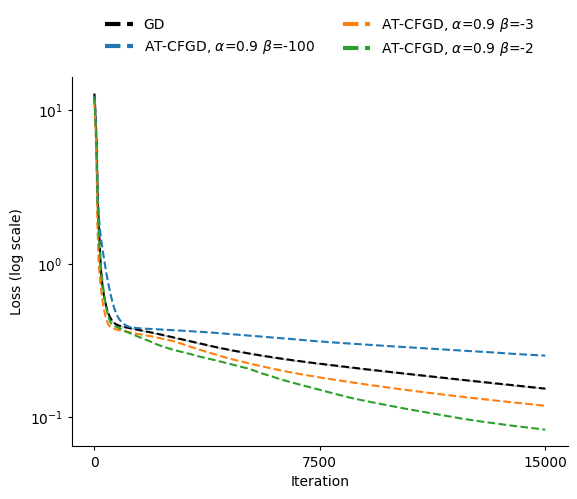

AT-CFGD, $\alpha$=0.9 $\beta$=-2    3269.272595413029
AT-CFGD, $\alpha$=0.9 $\beta$=-3    3507.9419118463993
GD    4342.834783598781
AT-CFGD, $\alpha$=0.9 $\beta$=-100    5551.172721147537


In [32]:
plot_metrics(
    baselines={
        k: r for k, r in runs.items() if "L2O-CFGD" not in k
    },
    l2os={
        k: r for k, r in runs.items() if "L2O-CFGD" in k
    },
    metrics=["loss"],
    # metrics=["test_error"],
    # show_max_iters=1000,
    log_metric=True,
    with_err_bars=True,
    conv_window=200,
    save_fig_to_path=None,
)
losses = []
for k, run_log in runs.items():
    losses.append((k, np.array(run_log["log"]["loss"]).sum()))
for (k, l) in sorted(losses, key=lambda x: x[1]):
    print(k, "  ", l)

In [ ]:
to_plot_pred = torch.cat((optee(task=eval_data.sample()), eval_data.sample()["x"]), dim=1).detach().cpu().numpy()
to_plot_pred = np.array(sorted(to_plot_pred, key=lambda p: p[1]))

to_plot_target = torch.cat((eval_data.sample()["y"], eval_data.sample()["x"]), dim=1).detach().cpu().numpy()
to_plot_target = np.array(sorted(to_plot_target, key=lambda p: p[1]))

plt.plot(to_plot_target[0:-1:1000,1], to_plot_target[0:-1:1000,0])
plt.plot(to_plot_pred[0:-1:1000,1], to_plot_pred[0:-1:1000,0])

In [ ]:
lrs = np.array(runs["L2O-CFGD"]["log"]["last_lr"][-1])
plt.plot(lrs[:, 0], label="Param #0")
plt.plot(lrs[:, 1], label="Param #1")
plt.plot(lrs[:, 2], label="Param #2")
plt.legend()

In [ ]:
plt.plot(runs["GD"]["log"]["test_error"][0])

### Analysis

In [ ]:
hparams = dict()
for hyperparam_name in ("alpha", "beta", "c"):
    per_param_alphas = []
    for param_idx in range(len(runs["L2O-CFGD"]["log"][hyperparam_name][0][0])):
        per_param_alphas.append([])
        for i in range(len(runs["L2O-CFGD"]["log"][hyperparam_name])):
            per_param_alphas[-1].append([])
            for j in range(len(runs["L2O-CFGD"]["log"][hyperparam_name][i])):
                per_param_alphas[-1][-1].append(
                    runs["L2O-CFGD"]["log"][hyperparam_name][i][j][param_idx]
                )
    for param_idx in range(len(runs["L2O-CFGD"]["log"][hyperparam_name][0][0])):
        per_param_alphas[param_idx] = np.stack(per_param_alphas[param_idx]).reshape(n_test_runs, test_run_iters, -1)
    hparams[hyperparam_name] = per_param_alphas

In [ ]:
param_idx = 0
test_run_idx = 0
to_plot_name = "alpha"
plot_plot_label = r"$\alpha$"
log_plot = False
max_components = 400
component_idxs = np.random.choice(hparams[to_plot_name][param_idx].shape[-1], size=min(max_components, hparams[to_plot_name][param_idx].shape[-1]), replace=False)

In [ ]:
### plotting config
to_plot_label = r"$\beta$"
to_plot_test_run_idx = 3
to_plot_label_cleaned = ''.join(e for e in to_plot_label if e.isalnum())
# to_plot = np.stack(runs["L2O-CFGD"]["log"][to_plot_label_cleaned])[0].squeeze()  # (n_test_runs, n_iters, D)
to_plot = hparams[to_plot_label_cleaned][param_idx][to_plot_test_run_idx,:,component_idxs].T

### where to save the figure
fig_dir = "../results/h2"
fig_name = f"{to_plot_label_cleaned}_{test_run_iters}iters_{to_plot_test_run_idx}run.pdf"
save_fig_to_path = os.path.join(fig_dir, fig_name)
save_fig_to_path = None # don't save
print(f"Final destination: {save_fig_to_path if save_fig_to_path is not None else 'None'}")

plot_strategy(
    to_plot=to_plot,
    y_label=to_plot_label,
    alpha_bg=0.08,
    conv_window_mean=50,
    save_fig_to_path=save_fig_to_path,
)

In [ ]:
fig = plt.figure(figsize=(15, 6), facecolor="w")
fig.suptitle(rf"L2O-CFGD: {plot_plot_label}", fontsize=16)
ax = fig.add_subplot(121)
if to_plot_name == "alpha":
    to_plot = hparams["alpha"][param_idx][:,:,component_idxs]
elif to_plot_name == "beta":
    to_plot = hparams["beta"][param_idx][:,:,component_idxs]
elif to_plot_name == "c":
    to_plot = hparams["c"][param_idx][:,:,component_idxs]
else:
    raise ValueError(f"Unknown to_plot: {to_plot_name}")

plt.plot(to_plot[test_run_idx].squeeze().reshape(test_run_iters, -1), alpha=0.1, color="grey")
plt.plot(to_plot[test_run_idx].squeeze().reshape(test_run_iters, -1).mean(-1), color="orange", linewidth=3)
ax.set_xlabel("Iteration", fontsize=13)
ax.set_ylabel(plot_plot_label, fontsize=13)

### share y-axis with left plot
ax = fig.add_subplot(122, sharey=ax)
plt.plot(to_plot[test_run_idx].squeeze().reshape(test_run_iters, -1)[:,:3])
ax.set_xlabel("Iteration", fontsize=13)
ax.set_ylabel(plot_plot_label, fontsize=13)
ax.legend(["Parameter #1", "Parameter #2", "Parameter #3"])

if log_plot:
    ax.set_yscale("log")

plt.tight_layout(h_pad=2.5)
# save_to = os.path.join(
#     config["ckpt_config"]["ckpt_dir"],
#     f"strategy_{to_plot_name}_{n_test_runs}runs_{test_run_iters}iters.png"
# )
# fig.savefig(save_to)

# fig.savefig("../results/strategy.eps", bbox_inches="tight")